In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization, RandomFlip, RandomRotation, RandomCrop
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop, RandomZoom, RandomContrast
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

## Загружаем данные

In [27]:
from google.colab import drive
drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/Machine_Learning/Powerful_machines/Train'
test_path = '/content/drive/MyDrive/Machine_Learning/Powerful_machines/Test'
valid_path = '/content/drive/MyDrive/Machine_Learning/Powerful_machines/Validation'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Набор данных для обучения**

In [28]:
# Организация трех наборов - тренировочная, валидационная и тестовая

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(300, 300),
    batch_size=60
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(300, 300),
    batch_size=60
)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(
    valid_path,
    image_size=(300, 300),
    batch_size=60
)

Found 4200 files belonging to 2 classes.
Found 1200 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [29]:
class_names = train_data.class_names
class_names

['Faulty', 'Healthy']

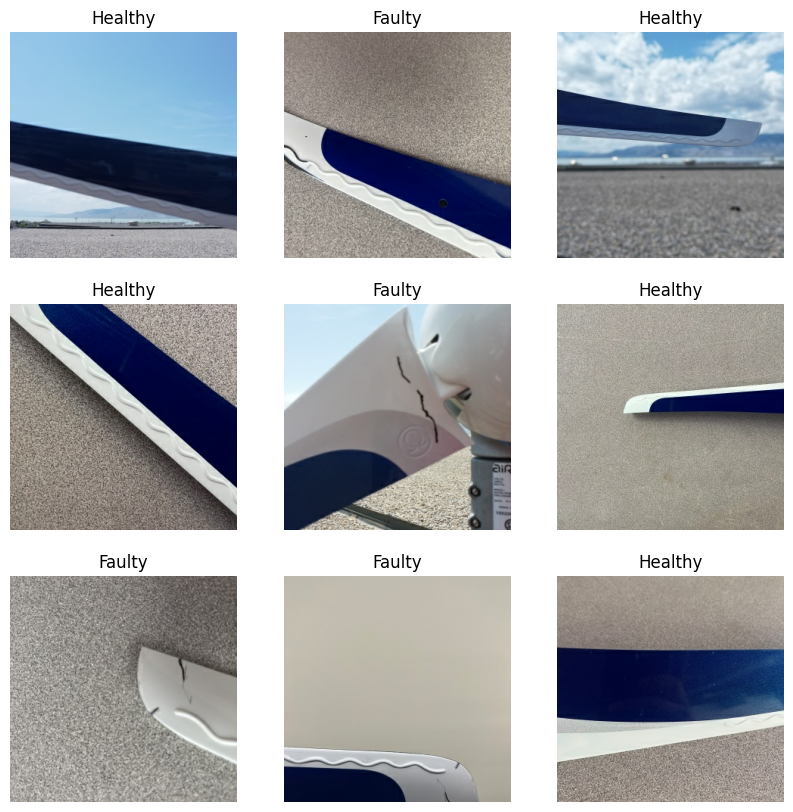

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [31]:
test_data.class_names

['Faulty', 'Healthy']

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_data.prefetch(buffer_size=AUTOTUNE)
validation_dataset = valid_data.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_data.prefetch(buffer_size=AUTOTUNE)

## Применение аугментации изображений для обучения


In [33]:
data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal")) # отражение изображения по горизонтали или вертикали
data_augmentation.add(RandomRotation(0.1))      # поворот изображения
# data_augmentation.add(RandomZoom(0.1))        # изменние масштаба изображения
# data_augmentation.add(RandomCrop(128, 128))   # вырезание фрагмента изображения из случайного места

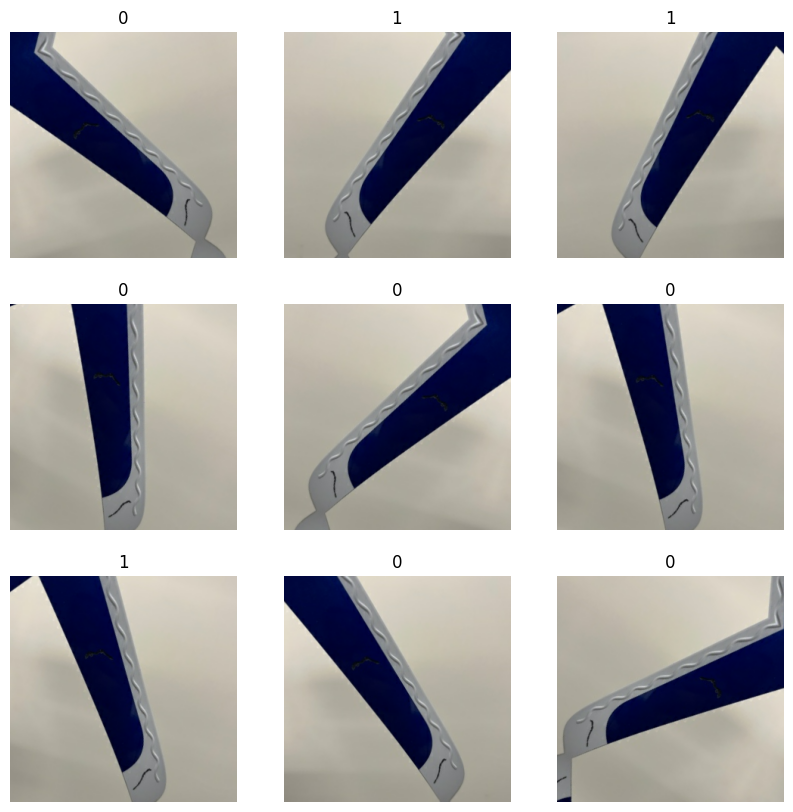

In [34]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Создаем нейронную сеть

In [35]:
vgg16_net = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(300, 300, 3))

In [36]:
vgg16_net.trainable = False

In [37]:
model = Sequential()
model.add(data_augmentation)
model.add(Normalization())
# Добавляем модель VGG16 в сеть как слой
model.add(vgg16_net)
model.add(Flatten())
model.add(Dense(600, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

**Компиляция модели**

In [38]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучение нейронной сети

In [39]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=15)

Epoch 1/15
70/70 [==============================] - 48s 640ms/step - loss: 5.8633 - accuracy: 0.7217 - val_loss: 0.4459 - val_accuracy: 0.8183
Epoch 2/15
70/70 [==============================] - 50s 674ms/step - loss: 0.4809 - accuracy: 0.8133 - val_loss: 0.3003 - val_accuracy: 0.8667
Epoch 3/15
70/70 [==============================] - 48s 669ms/step - loss: 0.3616 - accuracy: 0.8464 - val_loss: 0.2770 - val_accuracy: 0.9033
Epoch 4/15
70/70 [==============================] - 46s 638ms/step - loss: 0.3406 - accuracy: 0.8543 - val_loss: 0.3456 - val_accuracy: 0.8683
Epoch 5/15
70/70 [==============================] - 44s 608ms/step - loss: 0.3110 - accuracy: 0.8779 - val_loss: 0.2636 - val_accuracy: 0.8950
Epoch 6/15
70/70 [==============================] - 46s 631ms/step - loss: 0.2918 - accuracy: 0.8921 - val_loss: 0.2371 - val_accuracy: 0.9200
Epoch 7/15
70/70 [==============================] - 45s 620ms/step - loss: 0.2545 - accuracy: 0.9005 - val_loss: 0.2098 - val_accuracy: 0.9250

## Оцениваем качетсво обучения сети

In [44]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)


20/20 [==============================] - 11s 488ms/step - loss: 0.1759 - accuracy: 0.9325


In [45]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 93.25


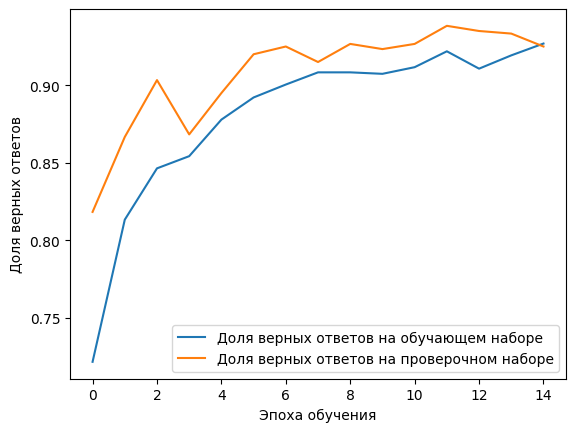

In [46]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

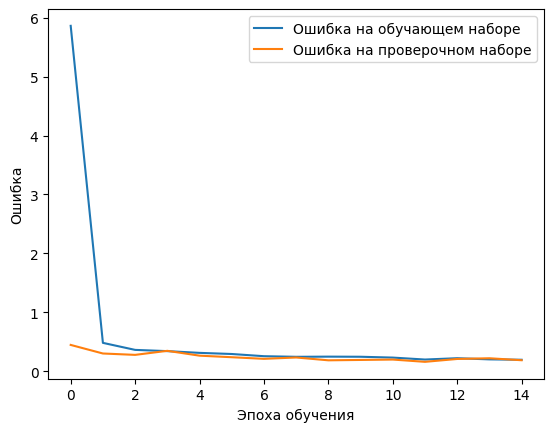

In [47]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [48]:
model.save("intel_image_model.h5")

In [50]:
# files.download("intel_image_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>